In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox

# Preprocessing

In [3]:
labels = pd.read_csv("../05-Detection/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        496 non-null    object
 1   x0           496 non-null    int64 
 2   y0           496 non-null    int64 
 3   w            496 non-null    int64 
 4   h            496 non-null    int64 
 5   name         496 non-null    object
 6   img_shape_x  496 non-null    int64 
 7   img_shape_y  496 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 31.1+ KB


In [5]:
ROOT_PATH = Path("../Datasets/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Datasets/HeartProcessed/")

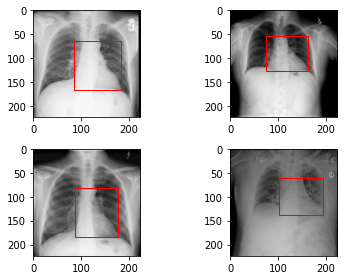

In [8]:
fig, axs = plt.subplots(2, 2)
c = 10
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data['name']
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        
        dcm = pydicom.dcmread(dcm_path).pixel_array
        dcm = cv2.resize(dcm, (224, 224))
        
        x = data['x0']
        y = data['y0']
        w = data["w"]
        h = data["h"]
        
        axs[i][j].imshow(dcm, cmap='gray')
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i][j].add_patch(rect)
        c += 1
plt.tight_layout()

In [20]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for c, pat_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/pat_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.dcmread(dcm_path).pixel_array
    dcm = (cv2.resize(dcm, (224, 224)) / 255).astype(np.float16)

    train_or_val = "train" if c < 400 else "val"
    
    if train_or_val == "train":
        train_ids.append(pat_id)
    else:
        val_ids.append(pat_id)
        
    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/pat_id, dcm)
    
    normalizer = dcm.shape[0] * dcm.shape[1]
    if train_or_val == "train":
        sums += np.sum(dcm) / normalizer
        sums_squared += np.power(dcm, 2).sum() / normalizer

In [21]:
sums

197.72066326530597

In [22]:
np.save("../Datasets/HeartProcessed/train_subjects_ids", train_ids)
np.save("../Datasets/HeartProcessed/val_subjects_ids", val_ids)

In [23]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - mean**2, dtype=np.float64)
print(f"Mean: {mean}  | Std: {std}")

Mean: 0.49430165816326493  | Std: 0.2527964897943661


In [4]:
mean = 0.49430165816326493
std = 0.2527964897943661

In [5]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, labels_path, patients, root_path, augs):
        
        self.labels = pd.read_csv(labels_path)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augments = augs
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        
        data = self.labels[self.labels['name']==patient]
        
        x_min = data['x0'].item()
        y_min = data['y0'].item()
        x_max = x_min + data['w'].item() 
        y_max = y_min + data['h'].item()
        
        bbox = [x_min, y_min, x_max, y_max]
        
        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        if self.augments:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)
            
            img, bbox_aug = self.augments(image = img, bounding_boxes = bb)
            bbox = bbox_aug[0][0], bbox_aug[0][1], bbox_aug[1][0], bbox_aug[1][1]
            
        img = (img - mean) / std
        
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        
        return img, bbox

In [6]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10)
    )
])

In [26]:
labels_path = "../05-Detection/rsna_heart_detection.csv"
patients = "../Datasets/HeartProcessed/train_subjects_ids.npy"
root_path = "../Datasets/HeartProcessed/train/"
dataset = CardiacDataset(labels_path, patients, root_path, seq)

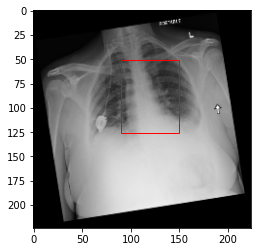

In [32]:
img, label = dataset[100]

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0], cmap='gray')
rect = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Training

In [7]:
labels_path = "../05-Detection/rsna_heart_detection.csv"
train_patients = "../Datasets/HeartProcessed/train_subjects_ids.npy"
train_root = "../Datasets/HeartProcessed/train/"
val_patients = "../Datasets/HeartProcessed/val_subjects_ids.npy"
val_root = "../Datasets/HeartProcessed/val/"


train_dataset = CardiacDataset(labels_path, train_patients, train_root, seq)
val_dataset = CardiacDataset(labels_path, val_patients, val_root, None)

In [8]:
batch_size = 8
num_workers = 12

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [9]:
print(len(train_loader), len(val_loader))

50 12


In [18]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = label[i]
            
            img = ((x_ray[i] * std) + mean).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
           
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [19]:
model = CardiacDetectionModel()

In [20]:
checkpoints = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="Detection-{epoch}-{Val Loss:.2f}",
    monitor="Val Loss",
    save_top_k=3,
    mode='min'
)

In [21]:
trainer = pl.Trainer(gpus=1, logger=TensorBoardLogger('logs/'), log_every_n_steps=1,
                    callbacks=checkpoints, max_epochs=5)

trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("../05-Detection/weight.ckpt")
model.eval()
model.to(device);

In [31]:
preds, targets = [], [] 

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        targets.append(label)
        
preds = torch.stack(preds)
targets = torch.stack(targets)

In [32]:
abs(pred - targets).mean(0)

tensor([ 9.6191,  9.3601, 12.8335, 17.0695])

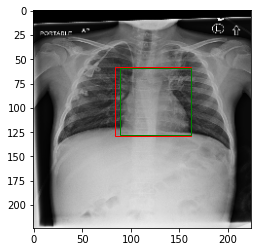

In [37]:
idx = 15
img, label = val_dataset[idx]
pred = preds[idx]

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0], cmap='gray')
rect1 = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], edgecolor='red', facecolor='none')
rect2 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='green', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

In [34]:
pred

tensor([ 77.0635,  44.0369, 167.4665, 129.5616])

In [35]:
label

tensor([ 85,  52, 174, 126])